# Customer churn

## Data description
### Features

- RowNumber - row index in the data
- CustomerId - unique identifier of the client
- Surname - last name
- CreditScore - credit rating
- Geography - country of residence
- Gender
- Age
- Tenure - number of properties the client has
- Balance - account balance
- NumOfProducts - number of bank products used by the client
- HasCrCard - availability of credit card
- IsActiveMember - activity of the client
- EstimatedSalary - estimated salary

### Target attribute
- Exited - the fact that the client has left


## Preparation of the data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm.notebook import tqdm
from sklearn.utils import shuffle

In [2]:
df = pd.read_csv('/project/datasets/Churn.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [5]:
duplicated_number = df.duplicated().sum()
duplicated_number

0

In [6]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Check for any inaccuracies in the writing of the categorical variables.

In [7]:
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [8]:
df['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [9]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [10]:
df['Tenure'].isna().mean()

0.0909

Nine percent of the customer's real estate data is missing.

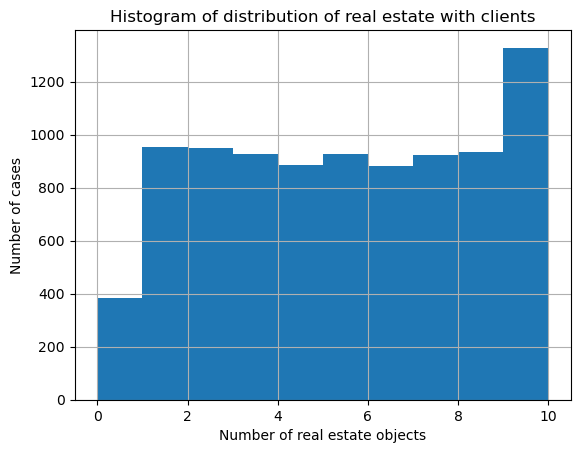

In [11]:
df['Tenure'].hist()
plt.xlabel('Number of real estate objects')
plt.ylabel('Number of cases')
plt.title('Histogram of distribution of real estate with clients')
plt.show()

The distribution is not symmetric, you can replace the gaps with the median.

In [12]:
df['Exited'].value_counts( )

0    7963
1    2037
Name: Exited, dtype: int64

There is a definite imbalance of classes in the target attribute. According to the data provided, 25% of customers left the bank, and 75% of customers stayed.

In [13]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [14]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'],axis = 1)

### Conclusion

The data table contains 14 columns and 10000 rows. There are gaps in the 'Tenure' variable (number of client real estate), it is possible to replace these gaps with a median, because the sample is asymmetric.
No duplicate records, no outliers detected in the data.

The columns 'RowNumber', 'CustomerId', 'Surname' are not needed for modeling purposes and were deleted.

## Problem Study

Separate the data for the test, as well as the features and the target feature for training and validation.

In [15]:
test = df.sample(frac=0.2,random_state=42)
train_full = df[~df.index.isin(test.index)]

features = train_full.drop(['Exited'],axis = 1)
target = train_full['Exited']


In [16]:
features_test = test.drop(['Exited'], axis = 1)
target_test = test['Exited']

Train the model with the pipeline module disregarding the class imbalance

In [17]:
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['Gender','Geography','NumOfProducts','HasCrCard',"IsActiveMember"]
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver = 'liblinear', random_state = 42))])
rfc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=10, random_state = 42))])
dtc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier(random_state = 42))])

X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.25,
                                                    random_state=42)

clf.fit(X_train, y_train)
rfc.fit(X_train, y_train)
dtc.fit(X_train, y_train)

predicted_clf = clf.predict(X_valid)
predicted_rfc = rfc.predict(X_valid)
predicted_dtc = dtc.predict(X_valid)
#print("model score: %.3f" % clf.score(X_test, y_test))
print("f1 score for the Logistic Regression model on the validation sample: %.3f" % f1_score(y_valid, predicted_clf))
print("f1 score for the Random Forest model on the validation sample: %.3f" % f1_score(y_valid, predicted_rfc))
print("f1 score for the Decision Tree model on the validation sample: %.3f" % f1_score(y_valid, predicted_dtc))

f1 score for the Logistic Regression model on the validation sample: 0.486
f1 score for the Random Forest model on the validation sample: 0.504
f1 score for the Decision Tree model on the validation sample: 0.471


### Conclusion.
Without taking into account target attribute class imbalance, the following values of measure f1 are obtained.

- f1 score for Logistic regression model on validation sample: 0.486
- f1 score for the Random Forest model on the validation sample: 0.544
- f1 score for the Decision Tree model in the validation sample: 0.471

## Unbalance correction

We stratify the classes of the target feature when partitioning into training and test samples with the stratify function.

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.25,
                                                    random_state=42, stratify = target)

clf.fit(X_train, y_train)
rfc.fit(X_train, y_train)
dtc.fit(X_train, y_train)

predicted_clf = clf.predict(X_valid)
predicted_rfc = rfc.predict(X_valid)
predicted_dtc = dtc.predict(X_valid)
#print("model score: %.3f" % clf.score(X_test, y_test))
print("f1 score for the Logistic Regression model on the validation sample: %.3f" % f1_score(y_valid, predicted_clf))
print("f1 score for the Random Forest model on the validation sample: %.3f" % f1_score(y_valid, predicted_rfc))
print("f1 score for the Decision Tree model on the validation sample: %.3f" % f1_score(y_valid, predicted_dtc))

f1 score for the Logistic Regression model on the validation sample: 0.474
f1 score for the Random Forest model on the validation sample: 0.513
f1 score for the Decision Tree model on the validation sample: 0.491


The f1 measure has increased slightly, but not yet enough.

Balancing the weight of the classes

In [19]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))])
rfc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=10,random_state=42, class_weight='balanced'))])
dtc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))])


clf.fit(X_train, y_train)
rfc.fit(X_train, y_train)
dtc.fit(X_train, y_train)

predicted_clf = clf.predict(X_valid)
predicted_rfc = rfc.predict(X_valid)
predicted_dtc = dtc.predict(X_valid)
#print("model score: %.3f" % clf.score(X_test, y_test))
print("f1 score the Logistic Regression model on the validation sample: %.3f" % f1_score(y_valid, predicted_clf))
print("f1 score for the Random Forest model on the validation sample: %.3f" % f1_score(y_valid, predicted_rfc))
print("f1 score for the Decision Tree model on the validation sample: %.3f" % f1_score(y_valid, predicted_dtc))

f1 score the Logistic Regression model on the validation sample: 0.558
f1 score for the Random Forest model on the validation sample: 0.513
f1 score for the Decision Tree model on the validation sample: 0.480


The measure f1 for the logistic regression and for the decision tree increased, and for the random forest decreased.

In [20]:
d = {'Classifier': ['Logistic Regression', 'Random Forest Classifier', 'Decision Tree Classifier'], 
     'F1 Score': [f1_score(y_valid, predicted_clf), f1_score(y_valid, predicted_rfc), f1_score(y_valid, predicted_dtc)]}
f1 = pd.DataFrame(data=d)
 
f1

,Classifier,F1 Score
0,Logistic Regression,0.558140
1,Random Forest Classifier,0.513057
2,Decision Tree Classifier,0.480192


In [21]:
from sklearn.metrics import roc_auc_score, roc_curve

d = {'Classifier': ['Logistic Regression', 'Random Forest Classifier','Decision Tree Classifier'], 
     '(ROC AUC) Score': [roc_auc_score(y_valid, predicted_clf), roc_auc_score(y_valid, predicted_rfc), roc_auc_score(y_valid, predicted_dtc)]}
rocauc = pd.DataFrame(data=d)
 
rocauc

,Classifier,(ROC AUC) Score
0,Logistic Regression,0.750426
1,Random Forest Classifier,0.680193
2,Decision Tree Classifier,0.673454


In [22]:
y_train.value_counts()

0    4767
1    1233
Name: Exited, dtype: int64

In [23]:
1233/4767

0.25865324103209564

Let's increase the sample size using the upsample method by writing a function

In [24]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

X_upsampled, y_upsampled = upsample(X_train, y_train, 4)

In [25]:
y_upsampled.value_counts()

1    4932
0    4767
Name: Exited, dtype: int64

In [26]:
clf.fit(X_upsampled, y_upsampled)
rfc.fit(X_upsampled, y_upsampled)
dtc.fit(X_upsampled, y_upsampled)

predicted_clf = clf.predict(X_valid)
predicted_rfc = rfc.predict(X_valid)
predicted_dtc = dtc.predict(X_valid)

In [27]:
d = {'Classifier': ['Logistic Regression', 'Random Forest Classifier', 'Decision Tree Classifier'], 
     'F1 Score': [f1_score(y_valid, predicted_clf), f1_score(y_valid, predicted_rfc), f1_score(y_valid, predicted_dtc)]}
f1 = pd.DataFrame(data=d)
 
f1

,Classifier,F1 Score
0,Logistic Regression,0.558659
1,Random Forest Classifier,0.541272
2,Decision Tree Classifier,0.465116


The F1-measure for the logistic regression and random forest models reached 0.56 and 0.53, respectively. Let us select the optimal hyperparameters.

In [28]:
best_result = 0
best_predicted_rfc = []
best_model = None
for depth in tqdm(range(10, 16, 1)):
    for est in tqdm(range(300, 700, 50)):
        rfc = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=42, class_weight='balanced'))])
        rfc.fit(X_upsampled, y_upsampled)
        predicted_rfc = rfc.predict(X_valid)
        result = f1_score(y_valid, predicted_rfc)
        if result > best_result:
                best_result = result
                best_depth = depth
                best_est = est
                best_forest_model = rfc
                best_predicted_rfc = predicted_rfc

print('Best f1_score for the Random Forest model', best_result)
print('Optimal height and number of trees:', best_depth, best_est)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Best f1_score for the Random Forest model 0.6029919447640967
Optimal height and number of trees: 11 650


In [29]:
best_result = 0
best_predicted_dtc = []
best_model = None
for depth in tqdm(range(1, 21, 1)):
    dtc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier(max_depth=depth, random_state=42, class_weight='balanced'))])
    dtc.fit(X_upsampled, y_upsampled)
    predicted_dtc = dtc.predict(X_valid)
    result = f1_score(y_valid, predicted_dtc)
    if result > best_result:
            best_result = result
            best_depth = depth
            best_tree_model = dtc
            best_predicted_dtc = predicted_dtc
print('The best f1_score for the Decision Tree model:', best_result)
print('Optimal tree height:', best_depth)

  0%|          | 0/20 [00:00<?, ?it/s]

Лучший f1_score для модели Дерева решений: 0.567922874671341
Оптимальная высота дерева: 5


In [30]:
param_grid = {
    'preprocessor__num__imputer__strategy': ['median'],
    'classifier__C': [0.1, 1.0, 10, 100],
    'classifier__penalty':['l1','l2']
}
grid_search = GridSearchCV(clf, param_grid, cv=10, scoring = 'f1')
#grid_search

In [31]:
grid_search.fit(X_upsampled, y_upsampled)
print(f"Best params:")
print(grid_search.best_params_)

Best params:
{'classifier__C': 1.0, 'classifier__penalty': 'l1', 'preprocessor__num__imputer__strategy': 'median'}


In [32]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced',penalty='l1', C=1))])

In [33]:
best_logreg_model = clf.fit(X_upsampled, y_upsampled)
predicted_clf = best_logreg_model.predict(X_valid)
best_predicted_clf = predicted_clf
print('The best f1_score for the Logistic Regression model:', f1_score(y_valid, predicted_clf))

Лучший f1_score для модели Логистической регрессии: 0.558659217877095


In [34]:
d = {'Classifier': ['Logistic Regression', 'Random Forest Classifier','Decision Tree Classifier'], 
     'F1 Score': [f1_score(y_valid, best_predicted_clf), f1_score(y_valid, best_predicted_rfc), f1_score(y_valid, best_predicted_dtc)]}
f1_upsampled = pd.DataFrame(data=d)
 
f1_upsampled

,Classifier,F1 Score
0,Logistic Regression,0.558659
1,Random Forest Classifier,0.602992
2,Decision Tree Classifier,0.567923


In [35]:
d = {'Classifier': ['Logistic Regression', 'Random Forest Classifier','Decision Tree Classifier'], 
     '(ROC AUC) Score': [roc_auc_score(y_valid, best_predicted_clf), roc_auc_score(y_valid, best_predicted_rfc), roc_auc_score(y_valid, best_predicted_dtc)]}
rocauc_upsampled = pd.DataFrame(data=d)
 
rocauc_upsampled

,Classifier,(ROC AUC) Score
0,Logistic Regression,0.750741
1,Random Forest Classifier,0.757061
2,Decision Tree Classifier,0.766407


Check f1_score models after reducing the sample to eliminate class imbalance

In [36]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

In [37]:
X_downsampled, y_downsampled = downsample(X_train, y_train, 0.1)

In [38]:
ds_dtc = best_tree_model.fit(X_downsampled, y_downsampled)
ds_predicted_dtc = ds_dtc.predict(X_valid)
print(f1_score(y_valid, ds_predicted_dtc))

0.5076660988074958


In [39]:
ds_rfc = best_forest_model.fit(X_downsampled, y_downsampled)
ds_predicted_rfc = ds_rfc.predict(X_valid)
print(f1_score(y_valid, ds_predicted_rfc))

0.5003427004797807


In [40]:
ds_clf = best_logreg_model.fit(X_downsampled, y_downsampled)
ds_predicted_clf = ds_clf.predict(X_valid)
print(f1_score(y_valid, ds_predicted_clf))

0.5638200183654728


### Conclusion

After eliminating class imbalances by upsampling, selecting hyperparameters, and setting class weights in the models as balanced, the following results were obtained on the validation sample:

- The best model was obtained based on the Random Forest classifier. The measure of F1 after checking on the validation sample for this model was 0.60
- Next is a model based on the decision tree classifier for which F1 was 0.57
- In third place is the model based on the Logistic Regression classifier with an F1 measure of 0.56

By balancing the weights of classes, eliminating class imbalance by upsampling, and selecting hyperparameters, the measure of F1 on the validation sample for the Random Forest model increased from 0.54 to 0.60

Eliminating class imbalance by downsampling yielded no positive results.

The highest Score of the ROC AUC measure was observed for the model with the Logistic Regression classifier and was 0.75; for the models with the Random Forest and Decision Tree classifiers, the ROC AUC measure was almost equal (0.68) with a difference of the third decimal place.


## Testing the model

Let's test the model on the test sample, which was set aside at the beginning of the work.

In [41]:
best_forest_model.fit(X_upsampled, y_upsampled)
predicted_rfc_test = best_forest_model.predict(features_test)
f1_score(target_test, predicted_rfc_test)

0.608294930875576

### Conclusion.
On the test sample, the model based on the Random Forest classifier behaved better than on the validation sample. The value of F1 score for the test sample was 0.61

## Overall conclusion.

The data provided required minor preprocessing prior to model training, namely replacing missing values in the customer real estate data with the median. 

Before training the models, Pipeline was created taking into account the categorical features coding by OneHotEncoding and scaling the quantitative features by StandarnScaler, replacing the gaps with the median.

A class imbalance was found in the target trait of 4 to 1. 

Without class imbalance, the models showed a low F1-score, with a maximum of 0.54 for the model with the Random Forest classifier.

After eliminating class imbalance by upsampling, selecting hyperparameters, and setting class weights in the models as balanced, the following results were obtained on the validation sample:

- The best model was obtained based on the Random Forest classifier. The F1 Score after validation in the validation sample for this model was 0.60

The highest Score of the ROC AUC measure was observed for the model with the Logistic Regression classifier and was 0.75, for the models with the Random Forest and Decision Tree classifiers the ROC AUC measure was almost equal (0.68) with the difference in the third decimal place.
